<a href="https://colab.research.google.com/github/rithikkulkarni/Video-Virality/blob/main/notebooks/classification_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 YouTube Video Virality – Binary Classification
This notebook builds classification models to predict whether a YouTube video will go **viral (1)** or **not viral (0)** using image and text-based features.


In [1]:
!pip install imbalanced-learn xgboost

In [8]:
import pandas as pd
import numpy as np

# Load your dataset
url = "https://raw.githubusercontent.com/rithikkulkarni/Video-Virality/refs/heads/main/data/video_details_v5.csv"
df = pd.read_csv(url)

# Filter out ResNet features
resnet_cols = [col for col in df.columns if col.startswith("resnet_")]
drop_cols = ["video_id", "thumbnail_text", "title", "channel_id",
             "viewCount", "likeCount", "commentCount", "viral"] + resnet_cols

X = df.drop(columns=drop_cols)
y = df["viral"]

# Check class balance
print("Viral = 1:", sum(y), f"({round(100 * sum(y)/len(y), 2)}%)")
print("Viral = 0:", len(y) - sum(y))

Viral = 1: 163 (8.15%)
Viral = 0: 1836


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=(sum(y==0) / sum(y==1)), use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SMOTE + Random Forest": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time
import seaborn as sns

def evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name):
    start = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    print(f"📊 {model_name}")
    print(f"⏱ Training time: {round(elapsed, 2)}s")
    print(classification_report(y_test, preds, digits=3))
    print("ROC AUC:", round(roc_auc_score(y_test, probs), 3))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Viral", "Viral"], yticklabels=["Not Viral", "Viral"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, probs):.2f})")


🔹 Logistic Regression
📊 Logistic Regression
⏱ Training time: 0.01s
              precision    recall  f1-score   support

           0      0.945     0.610     0.742       367
           1      0.123     0.606     0.204        33

    accuracy                          0.610       400
   macro avg      0.534     0.608     0.473       400
weighted avg      0.877     0.610     0.697       400

ROC AUC: 0.625


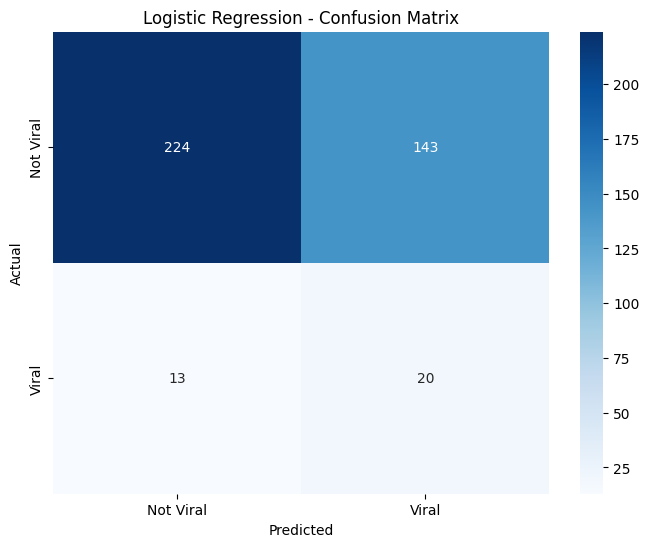


🔹 Random Forest
📊 Random Forest
⏱ Training time: 0.4s
              precision    recall  f1-score   support

           0      0.917     1.000     0.957       367
           1      0.000     0.000     0.000        33

    accuracy                          0.917       400
   macro avg      0.459     0.500     0.478       400
weighted avg      0.842     0.917     0.878       400

ROC AUC: 0.618


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


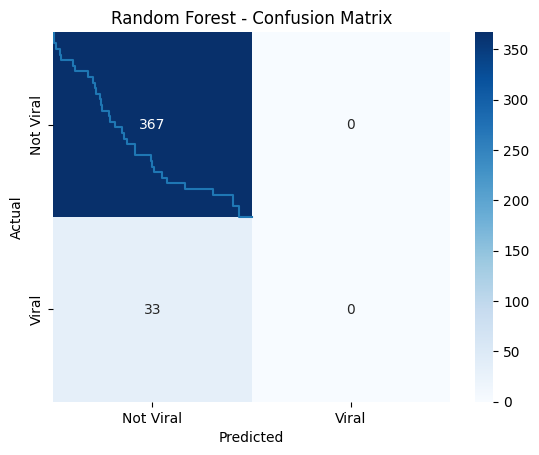


🔹 XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:51:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 XGBoost
⏱ Training time: 0.15s
              precision    recall  f1-score   support

           0      0.918     0.970     0.943       367
           1      0.083     0.030     0.044        33

    accuracy                          0.892       400
   macro avg      0.500     0.500     0.494       400
weighted avg      0.849     0.892     0.869       400

ROC AUC: 0.607


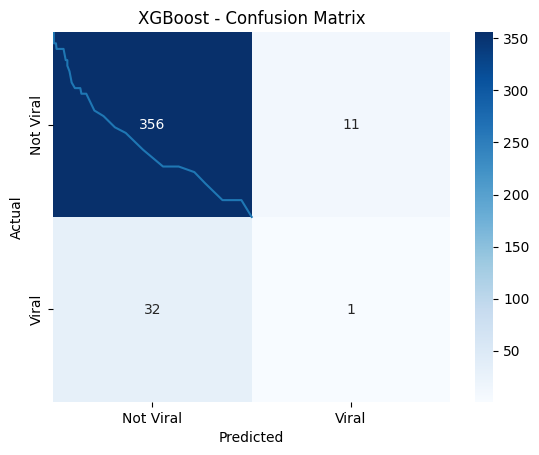


🔹 SMOTE + Random Forest
📊 SMOTE + Random Forest
⏱ Training time: 0.77s
              precision    recall  f1-score   support

           0      0.922     0.967     0.944       367
           1      0.200     0.091     0.125        33

    accuracy                          0.895       400
   macro avg      0.561     0.529     0.535       400
weighted avg      0.863     0.895     0.877       400

ROC AUC: 0.638


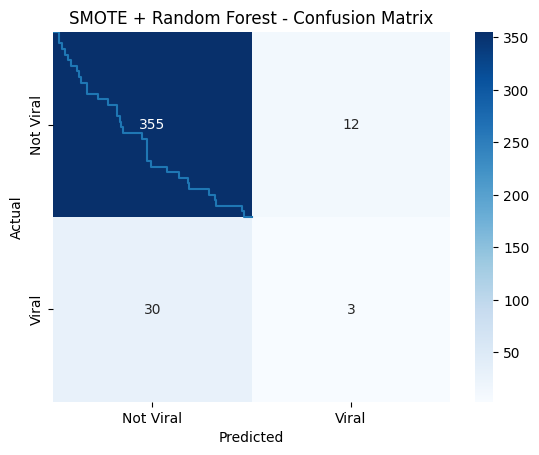

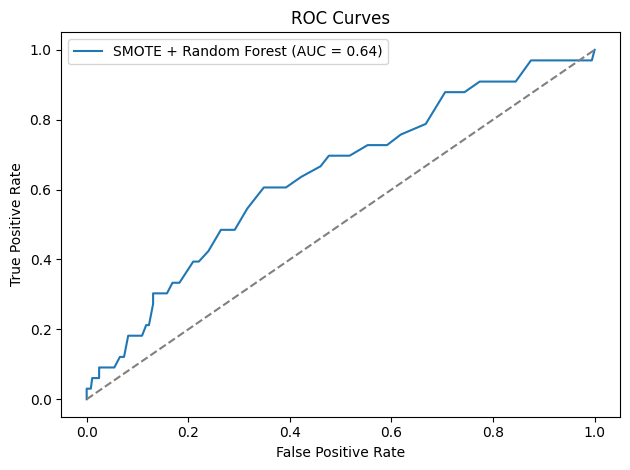

In [12]:
plt.figure(figsize=(8, 6))

for name, model in models.items():
    print(f"\n🔹 {name}")
    evaluate_classifier(model, X_train_scaled, y_train, X_test_scaled, y_test, name)

# Finish ROC curve plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
print("Columns in X:", X.columns.tolist())
print("Does X contain 'viewCount'? ", 'viewCount' in X.columns)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target distribution:", y_train.value_counts(normalize=True))
print("Test target distribution:", y_test.value_counts(normalize=True))

Columns in X: ['avg_red', 'avg_green', 'avg_blue', 'brightness', 'contrast', 'text_word_count', 'text_sentiment', 'title_sentiment', 'title_subjectivity', 'has_question', 'has_exclamation', 'starts_with_keyword', 'title_length', 'word_count', 'punctuation_count', 'uppercase_word_count', 'percent_letters_uppercase', 'has_numbers', 'clickbait_score', 'has_power_words', 'has_timed_words', 'viral']
Does X contain 'viewCount'?  False
Train shape: (1599, 22) Test shape: (400, 22)
Train target distribution: viral
0    0.918699
1    0.081301
Name: proportion, dtype: float64
Test target distribution: viral
0    0.9175
1    0.0825
Name: proportion, dtype: float64
